In [1]:
from plyfile import PlyData
import numpy as np
import torch

from splat.gaussians import Gaussians

xyz = np.load("luma/xyz.npy")
colors = np.load("luma/rgb_values.npy")
rots = np.load("luma/rots.npy")
scales = np.load("luma/scales.npy")
opacity = np.load("luma/opacities.npy")

gaussians = Gaussians(
    points=torch.Tensor(xyz),
    colors=torch.Tensor(colors),
    opacity=opacity,
    scale=scales,
    quaternion=rots,
)

In [2]:
data = PlyData.read("Downstairs_point_cloud.ply")
x = data["vertex"]["x"]
y = data["vertex"]["y"]
z = data["vertex"]["z"]
xyz = np.stack((x, y, z), axis=1)
colors = np.stack((data["vertex"]["red"], data["vertex"]["green"], data["vertex"]["blue"]), axis=1)
gaussians = Gaussians(
    points=torch.Tensor(xyz),
    colors=torch.Tensor(colors),
)

In [3]:
import matplotlib.pyplot as plt
from splat.gaussian_scene import GaussianScene

colmap_path = "treehill/sparse/0"

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)


In [4]:
cuda_src = """
#include <cstdio>
#include <cmath> // Include this header for expf function
#include <torch/extension.h>

__device__ float compute_pixel_strength(
    int pixel_x,
    int pixel_y,
    int point_x,
    int point_y,
    float inverse_covariance_a,
    float inverse_covariance_b,
    float inverse_covariance_c)
{
    // Compute the distance between the pixel and the point
    float dx = pixel_x - point_x;
    float dy = pixel_y - point_y;
    float power = dx * inverse_covariance_a * dx + 2 * dx * dy * inverse_covariance_b + dy * dy * inverse_covariance_c;
    return expf(-0.5f * power);
}

__global__ void render_tile(
    int image_height,
    int image_width,
    int tile_size,
    int num_points,
    float *point_means,
    float *point_colors,
    float *image,
    float *inverse_covariance_2d,
    float *min_x,
    float *max_x,
    float *min_y,
    float *max_y,
    float *opacity)
{
    // Calculate the pixel's position in the image
    int pixel_x = blockIdx.x * tile_size + threadIdx.x;
    int pixel_y = blockIdx.y * tile_size + threadIdx.y;

    // Ensure the pixel is within the image bounds
    if (pixel_x >= image_width || pixel_y >= image_height)
    {
        return;
    }

    float total_weight = 1.0f;
    float3 color = {0.0f, 0.0f, 0.0f};

    for (int i = 0; i < num_points; i++)
    {
        float point_x = point_means[i * 2];
        float point_y = point_means[i * 2 + 1];

        // checks to make sure we are within the bounding box
        bool x_check = pixel_x >= min_x[i] && pixel_x <= max_x[i];
        bool y_check = pixel_y >= min_y[i] && pixel_y <= max_y[i];
        if (!x_check || !y_check)
        {
            continue;
        }
        float strength = compute_pixel_strength(
            pixel_x,
            pixel_y,
            point_x,
            point_y,
            inverse_covariance_2d[i * 4],
            inverse_covariance_2d[i * 4 + 1],
            inverse_covariance_2d[i * 4 + 3]);
        
        float alpha = opacity[i] * strength;
        float test_weight = total_weight * (1 - alpha);
        if (test_weight < 0.001f)
        {
            break;
        }
        color.x += total_weight * alpha * point_colors[i * 3];
        color.y += total_weight * alpha * point_colors[i * 3 + 1];
        color.z += total_weight * alpha * point_colors[i * 3 + 2];
        total_weight = test_weight;
    }

    image[(pixel_y * image_width + pixel_x) * 3] = color.x;
    image[(pixel_y * image_width + pixel_x) * 3 + 1] = color.y;
    image[(pixel_y * image_width + pixel_x) * 3 + 2] = color.z;

}


torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity)
{
    // Ensure the input tensors are on the same device
    torch::TensorArg point_means_t{point_means, "point_means", 1},
        point_colors_t{point_colors, "point_colors", 2},
        inverse_covariance_2d_t{inverse_covariance_2d, "inverse_covariance_2d", 3},
        min_x_t{min_x, "min_x", 4},
        max_x_t{max_x, "max_x", 5},
        min_y_t{min_y, "min_y", 6},
        max_y_t{max_y, "max_y", 7},
        opacity_t{opacity, "opacity", 8};
    torch::checkAllSameGPU("render_image", {point_means_t, point_colors_t, inverse_covariance_2d_t, min_x_t, max_x_t, min_y_t, max_y_t, opacity_t});

    
    // Create an output tensor for the image
    torch::Tensor image = torch::zeros({image_height, image_width, 3}, point_means.options());

    // Calculate the number of tiles in the image
    int num_tiles_x = (image_width + tile_size - 1) / tile_size;
    int num_tiles_y = (image_height + tile_size - 1) / tile_size;

    // Launch a CUDA kernel to render the image
    dim3 block(tile_size, tile_size);
    dim3 grid(num_tiles_x, num_tiles_y);
    render_tile<<<grid, block>>>(
        image_height,
        image_width,
        tile_size,
        point_means.size(0),
        point_means.data_ptr<float>(),
        point_colors.data_ptr<float>(),
        image.data_ptr<float>(),
        inverse_covariance_2d.data_ptr<float>(),
        min_x.data_ptr<float>(),
        max_x.data_ptr<float>(),
        min_y.data_ptr<float>(),
        max_y.data_ptr<float>(),
        opacity.data_ptr<float>());

    return image;
}
"""



cpp_src = """
torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity);
"""

In [5]:
import os

from torch.utils.cpp_extension import load_inline

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False):
    return load_inline(
        name="inline_ext",
        cpp_sources=[cpp_src],
        cuda_sources=[cuda_src],
        functions=funcs,
        extra_cuda_cflags=["-O1"] if opt else [],
        verbose=verbose
    )

# Set MAX_JOBS for parallel compilation
os.environ['MAX_JOBS'] = '10'

# Compile and load the CUDA module
module = load_cuda(cuda_src, cpp_src, ["render_image"], opt=True, verbose=True)

Using /home/da2986/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Using envvar MAX_JOBS (10) as the number of workers...


ninja: no work to do.


Loading extension module inline_ext...


In [11]:
image.max()

tensor(0.3313, device='cuda:0')

Number of points:  tensor(144031, device='cuda:0')
Operation took seconds:  13.568422317504883


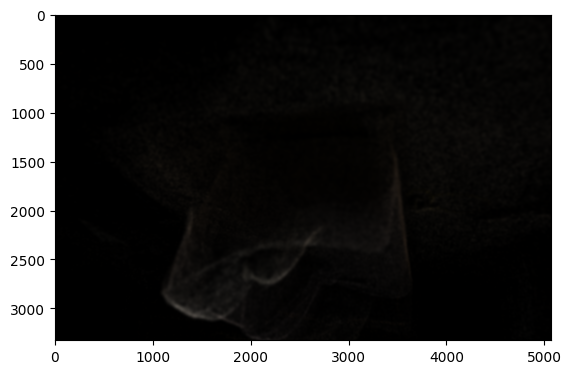

In [12]:
import os

image_num = 100

image = scene.render_image_cuda(image_num, module, tile_size=16)
from matplotlib import pyplot as plt

plt.imshow(image.detach().cpu())

In [7]:
image.max()

tensor(0.3313, device='cuda:0')

In [8]:
colors

array([[100,  73,  68],
       [ 61,  52,  71],
       [ 38,  43,  82],
       ...,
       [ 79,  82,  71],
       [ 74,  76,  72],
       [ 70,  79,  69]], dtype=uint8)

In [9]:
image.detach().cpu() * 25600

tensor([[[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         ...,
         [202.3356, 183.0668, 150.3566],
         [205.0067, 185.4649, 152.3138],
         [207.5669, 187.7612, 154.1867]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         ...,
         [209.8402, 189.8511, 155.9255],
         [212.5127, 192.2500, 157.8830],
         [215.0661, 194.5397, 159.7501]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         ...,
         [217.3387, 196.6292, 161.4892],
         [220.0083, 199.0251, 163.4439],
         [222.5504, 201.3042, 165.3019]],

        ...,

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         ...,
         [ 76.1005,  69.1766,  61.4137],
         [ 80.7533,  7